# Gradient Boosting


Вы научитесь:

    работать с градиентным бустингом и подбирать его гиперпараметры
    сравнивать разные способы построения композиций
    понимать, в каком случае лучше использовать случайный лес, а в каком — градиентный бустинг

    использовать метрику log-loss
    
Введение

Построение композиции — важный подход в машинном обучении, который позволяет объединять большое количество слабых алгоритмов в один сильный. Данный подход широко используется на практике в самых разных задачах.

На лекциях был рассмотрен метод градиентного бустинга, который последовательно строит композицию алгоритмов, причем каждый следующий алгоритм выбирается так, чтобы исправлять ошибки уже имеющейся композиции. Обычно в качестве базовых алгоритмов используют деревья небольшой глубины, поскольку их достаточно легко строить, и при этом они дают нелинейные разделяющие поверхности.

Другой метод построения композиций — случайный лес. В нем, в отличие от градиентного бустинга, отдельные деревья строятся независимо и без каких-либо ограничений на глубину — дерево наращивается до тех пор, пока не покажет наилучшее качество на обучающей выборке.

В этом задании мы будем иметь дело с задачей классификации. В качестве функции потерь будем использовать log-loss:
    $$L(y, z) = -y log(z) - (1 - y) log(1 - z)$$
Здесь через y обозначен истинный ответ, через z — прогноз алгоритма. Данная функция является дифференцируемой, и поэтому подходит для использования в градиентном бустинге. Также можно показать, что при ее использовании итоговый алгоритм будет приближать истинные вероятности классов.
Реализация в sklearn

В пакете scikit-learn градиентный бустинг реализован в модуле ensemble в виде классов GradientBoostingClassifier и GradientBoostingRegressor. Основные параметры, которые будут интересовать нас: n_estimators, learning_rate. Иногда может быть полезен параметр verbose для отслеживания процесса обучения.

Чтобы была возможность оценить качество построенной композиции на каждой итерации, у класса есть метод staged_decision_function. Для заданной выборки он возвращает ответ на каждой итерации.

Помимо алгоритмов машинного обучения, в пакете scikit-learn представлено большое число различных инструментов. В этом задании будет предложено воспользоваться функцией train_test_split модуля cross_validation. С помощью нее можно разбивать выборки случайным образом. На вход можно передать несколько выборок (с условием, что они имеют одинаковое количество строк). Пусть, например, имеются данные X и y, где X — это признаковое описание объектов, y — целевое значение. Тогда следующий код будет удобен для разбиения этих данных на обучающее и тестовое множества:

    X_train, X_test, y_train, y_test = 
                         train_test_split(X, y, 
                                          test_size=0.33, 
                                          random_state=42)
Обратите внимание, что при фиксированном параметре random_state результат разбиения можно воспроизвести.

Метрика log-loss реализована в пакете metrics: sklearn.metrics.log_loss. Заметим, что данная метрика предназначена для классификаторов, выдающих оценку принадлежности классу, а не бинарные ответы. И градиентный бустинг, и случайный лес умеют строить такие прогнозы — для этого нужно использовать метод predict_proba:
    
    pred = clf.predict_proba(X_test)
    
Метод predict_proba возвращает матрицу, i-й столбец которой содержит оценки принадлежности i-му классу.

Для рисования кривых качества на обучении и контроле можно воспользоваться следующим кодом:
    
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.figure()
    plt.plot(test_loss, 'r', linewidth=2)
    plt.plot(train_loss, 'g', linewidth=2)
    plt.legend(['test', 'train'])


    Загрузите выборку из файла gbm-data.csv с помощью pandas и преобразуйте ее в массив numpy (параметр values у датафрейма). В первой колонке файла с данными записано, была или нет реакция. Все остальные колонки (d1 - d1776) содержат различные характеристики молекулы, такие как размер, форма и т.д. Разбейте выборку на обучающую и тестовую, используя функцию train_test_split с параметрами test_size = 0.8 и random_state = 241. 

In [1]:
import pandas as pd
data = pd.read_csv('gbm-data.csv')
print(data.shape)
data.tail(4)

(3751, 1777)


,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
3747,1,0.133333,0.651023,0.15,0.0,0.151154,0.766505,0.170876,0.404546,0.787935,...,0,0,1,0,1,0,1,0,0,0
3748,0,0.200000,0.520564,0.00,0.0,0.179949,0.768785,0.177341,0.471179,0.872241,...,0,0,0,0,0,0,0,0,0,0
3749,1,0.100000,0.765646,0.00,0.0,0.536954,0.634936,0.342713,0.447162,0.672689,...,0,0,0,0,0,0,0,0,0,0
3750,0,0.133333,0.533952,0.00,0.0,0.347966,0.757971,0.230667,0.272652,0.854116,...,0,0,0,0,0,0,0,0,0,0


In [2]:
data_arr = data.values
print(type(data_arr), data_arr.shape)

<class 'numpy.ndarray'> (3751, 1777)


In [3]:
X = data_arr[:, 1:]
y = data_arr[:, 0]
print(X.shape, y.shape)

(3751, 1776) (3751,)


In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=241)
print(X_train.shape, y_train.shape)

(3000, 1776) (3000,)


    Обучите GradientBoostingClassifier с параметрами n_estimators=250, verbose=True, random_state=241 и для каждого значения learning_rate из списка [1, 0.5, 0.3, 0.2, 0.1] проделайте следующее:

    Используйте метод staged_decision_function для предсказания качества на обучающей и тестовой выборке на каждой итерации.
    Преобразуйте полученное предсказание с помощью сигмоидной функции по формуле 1 / (1 + e^{−y_pred}), где y_pred — предсказанное значение.
    Вычислите и постройте график значений log-loss (которую можно посчитать с помощью функции sklearn.metrics.log_loss) на обучающей и тестовой выборках, а также найдите минимальное значение метрики и номер итерации, на которой оно достигается.

In [7]:
from sklearn.ensemble import GradientBoostingClassifier
from matplotlib import pyplot as plt
from sklearn.metrics import log_loss
import numpy as np

def analize_diff_rate(iterable):
    min_test_loss = {}
    for rate in iterable:
        gbc = GradientBoostingClassifier(n_estimators=1000, verbose=True, learning_rate=rate, random_state=241)
        gbc.fit(X_train, y_train)
        
        y_pred_train = [1 / (1 + np.exp(-i)) for i in gbc.staged_decision_function(X_train)] #i is np.array
        y_pred_test = [1 / (1 + np.exp(-i)) for i in gbc.staged_decision_function(X_test)]
        scores_train = {}
        scores_test = {}
        for i in range(len(y_pred_train)):
            scores_train[i] = log_loss(y_train, y_pred_train[i])
            scores_test[i] = log_loss(y_test, y_pred_test[i])    
        
        plt.title('log loss with rate: ' + str(rate))
        plt.plot(list(scores_train.keys()), list(scores_train.values()), 'b', linewidth=2)
        plt.plot(list(scores_test.keys()), list(scores_test.values()), 'r', linewidth=2)
        plt.legend(['train', 'test'])
        plt.show()
        
        test_loss = sorted(scores_test.items(), key=lambda x: x[1])
        min_test_loss[rate] = (test_loss[0][0], test_loss[0][1])
    return min_test_loss

      Iter       Train Loss   Remaining Time 
         1           1.2098            5.52m
         2           1.1164            5.50m
         3           1.0618            5.53m
         4           1.0240            5.53m
         5           0.9976            5.53m
         6           0.9739            5.45m
         7           0.9548            5.27m
         8           0.9378            5.21m
         9           0.9239            5.16m
        10           0.9117            5.12m
        20           0.8178            4.91m
        30           0.7517            4.60m
        40           0.6877            4.44m
        50           0.6416            4.31m
        60           0.5860            4.41m
        70           0.5500            4.33m
        80           0.5086            4.37m
        90           0.4820            4.38m
       100           0.4507            4.29m
       200           0.2466            3.71m
       300           0.1521            3.24m
       40

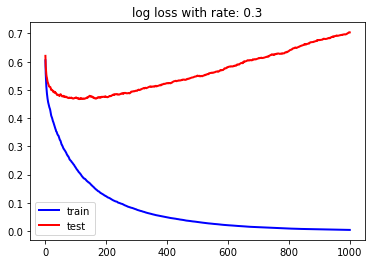

In [8]:
min_loss = analize_diff_rate([0.3])

    Как можно охарактеризовать график качества на тестовой выборке, начиная с некоторой итерации: переобучение (overfitting) или недообучение (underfitting)? В ответе укажите одно из слов overfitting либо underfitting.

In [7]:
with open('grad_boost_ans1.txt', 'w') as f:
    f.write('overfitting')
!cat grad_boost_ans1.txt

overfitting

Приведите минимальное значение log-loss на тестовой выборке и номер итерации, на котором оно достигается, при learning_rate = 0.2.

In [8]:
with open('grad_boost_ans2.txt', 'w') as f:
    f.write(' '.join([str(round(x, 2)) for x in [min_loss[0.2][1], min_loss[0.2][0]]]))
!cat grad_boost_ans2.txt

0.53 36

In [9]:
min_loss

{0.1: (51, 0.52692018722758438),
 0.2: (36, 0.53145079631906378),
 0.3: (10, 0.54231411100245541),
 0.5: (6, 0.55820255231642613),
 1: (0, 0.58229425942784763)}

На этих же данных обучите RandomForestClassifier с количеством деревьев, равным количеству итераций, на котором достигается наилучшее качество у градиентного бустинга из предыдущего пункта, c random_state=241 и остальными параметрами по умолчанию. Какое значение log-loss на тесте получается у этого случайного леса? (Не забывайте, что предсказания нужно получать с помощью функции predict_proba. В данном случае брать сигмоиду от оценки вероятности класса не нужно)

In [19]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=min_loss[0.2][0] * 20, random_state=241, n_jobs=-1)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=720, n_jobs=-1, oob_score=False, random_state=241,
            verbose=0, warm_start=False)

In [20]:
y_pred_test_rfc = [i[1] for i in rfc.predict_proba(X_test)]
loss_rfc = log_loss(y_test, y_pred_test_rfc)

In [21]:
loss_rfc

0.52309343555858268

In [18]:
with open('grad_boost_ans3.txt', 'w') as f:
    f.write(str(round(loss_rfc, 2)))
!cat grad_boost_ans3.txt

0.54